In [1]:
# !pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
# !pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

In [2]:
# !pip install git+https://github.com/iitzco/faced.git

In [3]:
import cv2
import numpy as np
import torch

# faced: https://github.com/iitzco/faced
from faced import FaceDetector
from faced.utils import annotate_image

# mtcnn: https://github.com/TropComplique/mtcnn-pytorch
from mtcnn.src import detect_faces

from os import listdir
from os.path import join
from time import time
from math import ceil
import pickle

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from PIL import Image

/home/egor/venvs/face_recognition/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/egor/venvs/face_recognition/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/egor/venvs/face_recognition/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/egor/venvs/face_recognition/lib/python3.6/s

# Face detectors comparison

## Detection comparison

W0806 14:07:09.436559 140471588366144 deprecation_wrapper.py:119] From /home/egor/venvs/face_recognition/lib/python3.6/site-packages/faced/detector.py:29: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0806 14:07:09.462747 140471588366144 deprecation_wrapper.py:119] From /home/egor/venvs/face_recognition/lib/python3.6/site-packages/faced/detector.py:32: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0806 14:07:09.463227 140471588366144 deprecation_wrapper.py:119] From /home/egor/venvs/face_recognition/lib/python3.6/site-packages/faced/detector.py:33: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.

W0806 14:07:09.599500 140471588366144 deprecation_wrapper.py:119] From /home/egor/venvs/face_recognition/lib/python3.6/site-packages/faced/detector.py:42: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Faced detections is red, MTCNN - green


/home/egor/job/face_detection/mtcnn/src/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile=True)
/home/egor/job/face_detection/mtcnn/src/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/home/egor/job/face_detection/mtcnn/src/detector.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
/home/egor/job/face_detection/mtcnn/src/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/home/egor/job/face_detection/mtcnn/src/detector.py:100: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Va

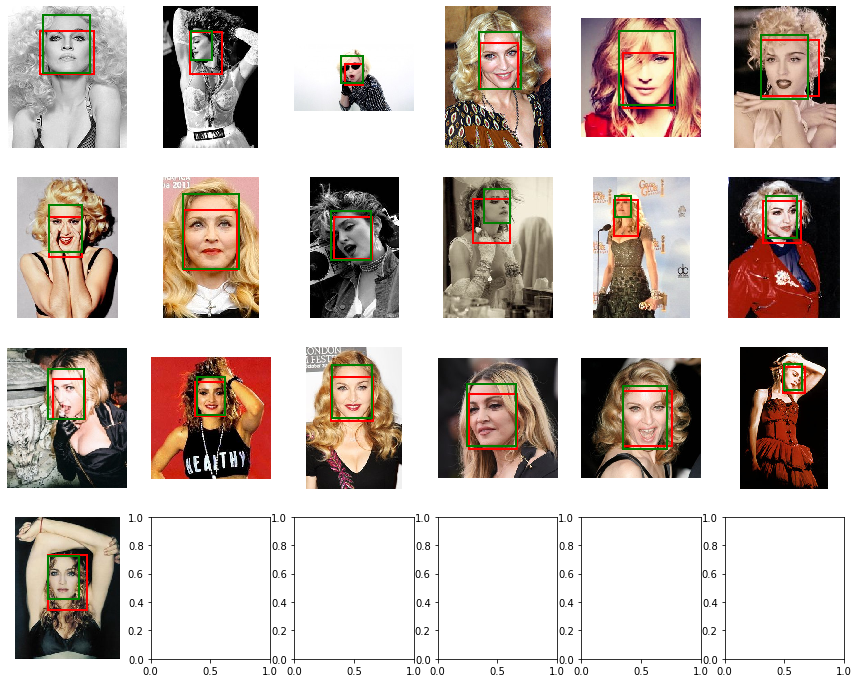

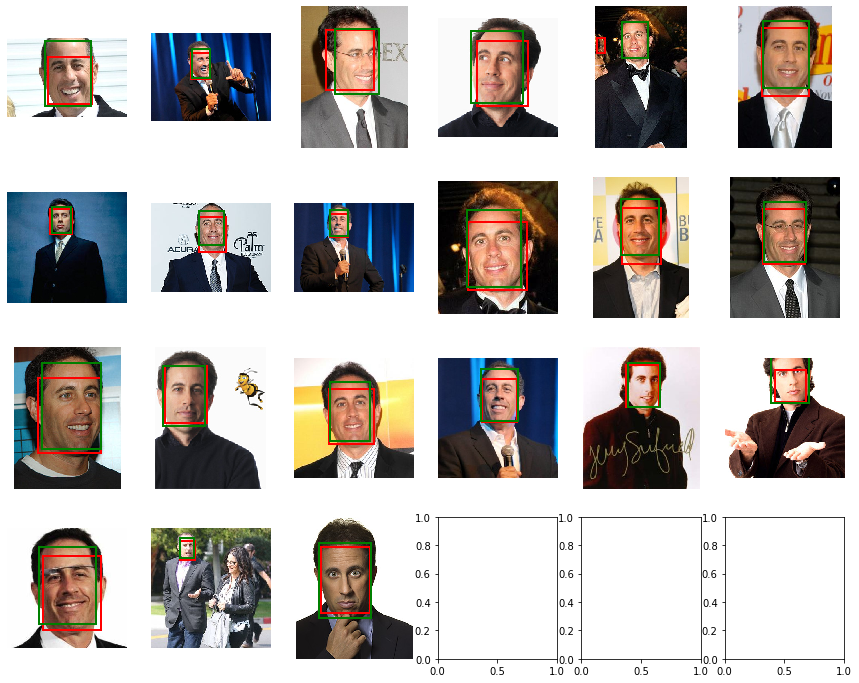

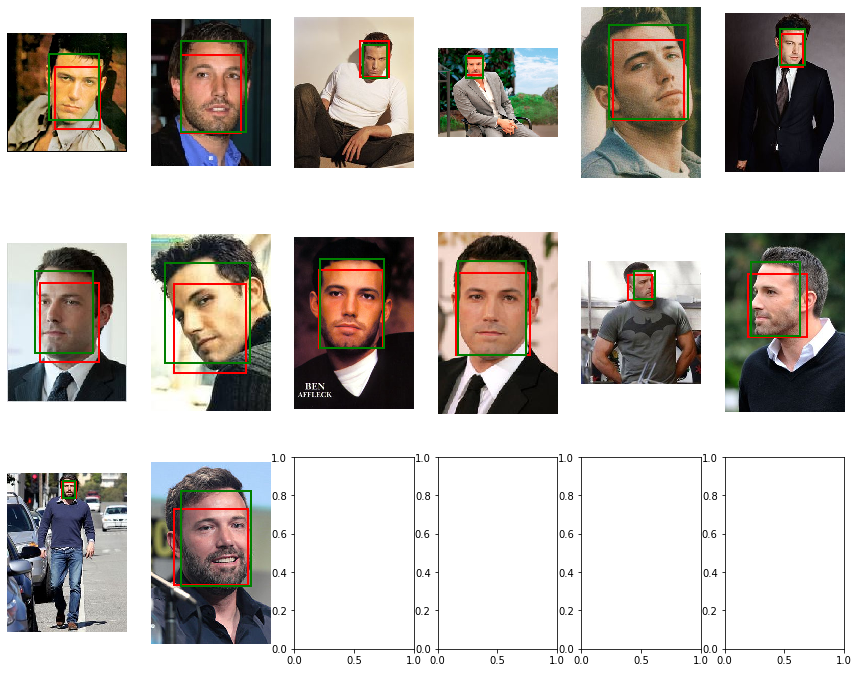

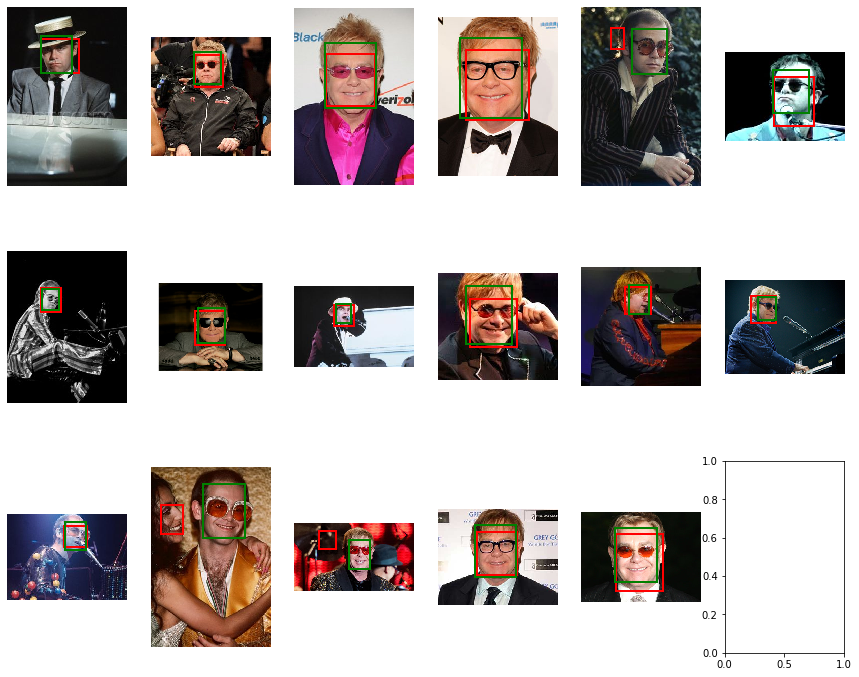

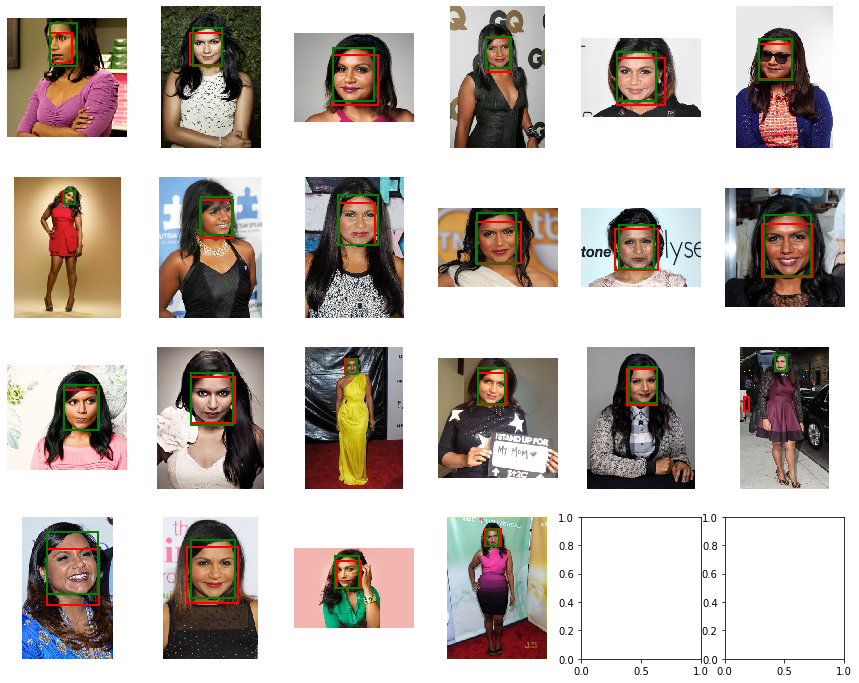

In [4]:
path = '/home/egor/job/face_detection/data/train'
folders = listdir(path)

face_detector = FaceDetector()

n_cols = 6

print('Faced detections is red, MTCNN - green')

for folder in folders:
    images = listdir(join(path, folder))
    
    fig, ax = plt.subplots(ceil(len(images) / n_cols), n_cols, figsize=(15, 12))
    for i, img in enumerate(images):
        img = cv2.imread(join(path, folder, img))
        rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_img)
        
        # faced detections 
        # Receives RGB numpy image (HxWxC) and
        # returns (x_center, y_center, width, height, prob) tuples. 
        bboxes = face_detector.predict(rgb_img, 0.5)
        x, y, w, h, _ = bboxes[0]
        x0, y0 = int(x - w/2), int(y - h/2)
        faced_rect = Rectangle((x0, y0), w, h, linewidth=2, edgecolor='r', facecolor='none')

        # mtcnn detections
        bounding_boxes, landmarks = detect_faces(pil_image)
        x0, y0, x1, y1 = [i for i in bounding_boxes[0][:4]]
        w, h = x1 - x0, y1 - y0
        mtcnn_rect = Rectangle((x0, y0), w, h, linewidth=2, edgecolor='g', facecolor='none')
        
        row, col = i // n_cols, i % n_cols
        ax[row][col].imshow(rgb_img)
        ax[row][col].add_patch(faced_rect)
        ax[row][col].add_patch(mtcnn_rect)
        ax[row][col].axis('off')
    plt.show()

## Speed comparison

In [5]:
faced_times = []

for folder in folders:
    images = listdir(join(path, folder))
    
    for i, image in enumerate(images):
        img = cv2.imread(join(path, folder, image))
        rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        
        t0 = time()
        bboxes = face_detector.predict(rgb_img, 0.5)
        dt = time() - t0
        faced_times.append(dt)

In [6]:
mtcnn_times = []

# mtcnn
for folder in folders:
    images = listdir(join(path, folder))
    
    for i, image in enumerate(images):
        img = cv2.imread(join(path, folder, image))
        rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_img)
        
        t0 = time()
        bounding_boxes, landmarks = detect_faces(pil_image)
        dt = time() - t0
        mtcnn_times.append(dt)

In [7]:
print('Faced detection time: mean {:.4f} sec, median {:.4f} sec'.format(np.mean(faced_times), 
                                                                        np.median(faced_times)))
print('MTCNN detection time: mean {:.4f} sec, median {:.4f} sec'.format(np.mean(mtcnn_times), 
                                                                        np.median(mtcnn_times)))
print()
print('Faced mean fps {:.4f}'.format(1. / np.mean(faced_times)))
print('MTCNN mean fps {:.4f}'.format(1. / np.mean(mtcnn_times)))

Faced detection time: mean 0.0212 sec, median 0.0212 sec
MTCNN detection time: mean 0.0512 sec, median 0.0493 sec

Faced mean fps 47.0802
MTCNN mean fps 19.5254


## Comparison conclusion

It's obvious that MTCNN gives better results than faced. Faced also makes mistakes. Despite the fact that faced is more than two times faster I'll use MTCNN for face detections.